In [ ]:
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer, EsmForMaskedLM
from tokenizers import Tokenizer
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
def initialize_esm2(model_name):
  # Define tokenizer and model
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = EsmForMaskedLM.from_pretrained(model_name).to(device)
  # Evaluate mode
  model.eval()
  return model, tokenizer

def collect_log_prob_esm2(sequence, model, tokenizer):
  # Define indices for log-likelihood ratio matrix
  amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
  aa_token_ids = [tokenizer.convert_tokens_to_ids(aa) for aa in amino_acids]

  # Clean sequence
  sequence.replace('\n','')
  sequence.replace(' ','')

  # Tokenize sequence for model
  inputs = tokenizer(sequence, return_tensors='pt', add_special_tokens=True)

  # Output predcitions from model, do not compute gradients
  with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

  input_ids = inputs['input_ids']

  # Define tensor of log probabilities for each
  # amino acid in each position of the sequence
  log_probs = torch.log_softmax(logits, dim=-1)

  # Define tensor of reference log probabilities
  # the log probabilities for actual amino acid
  # in sequence
  ref_log_probs = log_probs[0, torch.arange(input_ids.size(1)), input_ids[0]]
  # Resize ref_log_probs
  ref_log_probs = ref_log_probs.unsqueeze(1)
  log_probs = log_probs[0]

  # Define the log-likelihood ratio matrix
  llr_matrix = log_probs - ref_log_probs
  llr_matrix = llr_matrix[1:-1,:]
  llr_matrix = llr_matrix[:, aa_token_ids]
  log_probs = log_probs[1:-1,:]
  log_probs = log_probs[:, aa_token_ids]
  ref_log_probs = ref_log_probs[1:-1]

  return log_probs, ref_log_probs, llr_matrix


In [ ]:
def llr_heatmap(llr_matrix, positions=None, figsize=(15, 10), cmap='RdBu_r'):

  amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

  if positions is None:
    positions = np.arange(llr_matrix.shape[0])
  else:
    positions = list(positions)
  plt.figure(figsize=figsize)
  sns.heatmap(llr_matrix[positions,:].T,
              xticklabels=positions,
              yticklabels=list(amino_acids),
              cmap=cmap,
              center=0,
              cbar_kws={'label': 'LLR'})
  plt.xlabel('Position in CRX')
  plt.ylabel('Amino Acid')
  plt.title('Log-Likelihood Ratio Matrix')
  plt.tight_layout()

  return plt


In [ ]:
def seq_matrix_dict(sequence_list, model, tokenizer):

  seq_dict = dict()

  n = len(sequence_list)

  for i in range(n):
    sequence = sequence_list[i]
    lp, rlp, llr = collect_log_prob_esm2(sequence, model, tokenizer)

    seq_dict[i] = {'log_probs': lp, 'ref_log_probs': rlp, 'llr_matrix': llr}

  return seq_dict

In [ ]:
model_name = "facebook/esm2_t33_650M_UR50D"
crx_sequence = "MMAYMNPGPHYSVNALALSGPSVDLMHQAVPYPSAPRKQRRERTTFTRSQLEELEALFAKTQYPDVYAREEVALKINLPESRVQVWFKNRRAKCRQQRQQQKQQQQPPGGQAKARPAKRKAGTSPRPSTDVCPDPLGISDSYSPPLPGPSGSPTTAVATVSIWSPASESPLPEAQRAGLVASGPSLTSAPYAMTYAPASAFCSSPSAYGSPSSYFSGLDPYLSPMVPQLGGPALSPLSGPSVGPSLAQSPTSLSGQSYGAYSPVDSLEFKDPTGTWKFTYNPMDPLDYKDQSAWKFQIL"

In [ ]:
model, tokenizer = initialize_esm2(model_name)

In [ ]:
seq_matrix_dict([crx_sequence], model, tokenizer)

{0: {'log_probs': tensor([[ -7.2168,  -9.8979,  -8.3167,  ...,  -7.9946, -10.5813,  -8.1823],
          [ -2.2855,  -6.3548,  -2.8904,  ...,  -4.5856,  -5.9068,  -3.8871],
          [ -0.2848,  -6.4534,  -2.6801,  ...,  -5.3657,  -7.4193,  -4.6717],
          ...,
          [ -3.3514,  -4.7220,  -4.7567,  ...,  -4.5978,  -7.5169,  -3.9585],
          [ -2.5445,  -3.0540,  -5.4480,  ...,  -3.4196,  -6.1805,  -3.7552],
          [ -6.0708,  -5.7993,  -6.4749,  ...,  -5.1446,  -7.2423,  -4.3555]]),
  'ref_log_probs': tensor([[-6.1820e-03],
          [-6.1626e-01],
          [-2.8478e-01],
          [-4.9924e-01],
          [-6.9610e-01],
          [-7.9018e-01],
          [-1.7794e-01],
          [-4.8641e-01],
          [-3.4257e-01],
          [-9.7779e-01],
          [-6.3414e-01],
          [-2.4741e-01],
          [-6.7637e-01],
          [-8.4276e-01],
          [-4.2372e-01],
          [-3.7287e-01],
          [-2.6504e-01],
          [-3.0477e-01],
          [-2.7124e-01],
       

In [ ]:
crx_lp, crx_rlp, crx_llr = collect_log_prob_esm2(crx_sequence, model, tokenizer)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

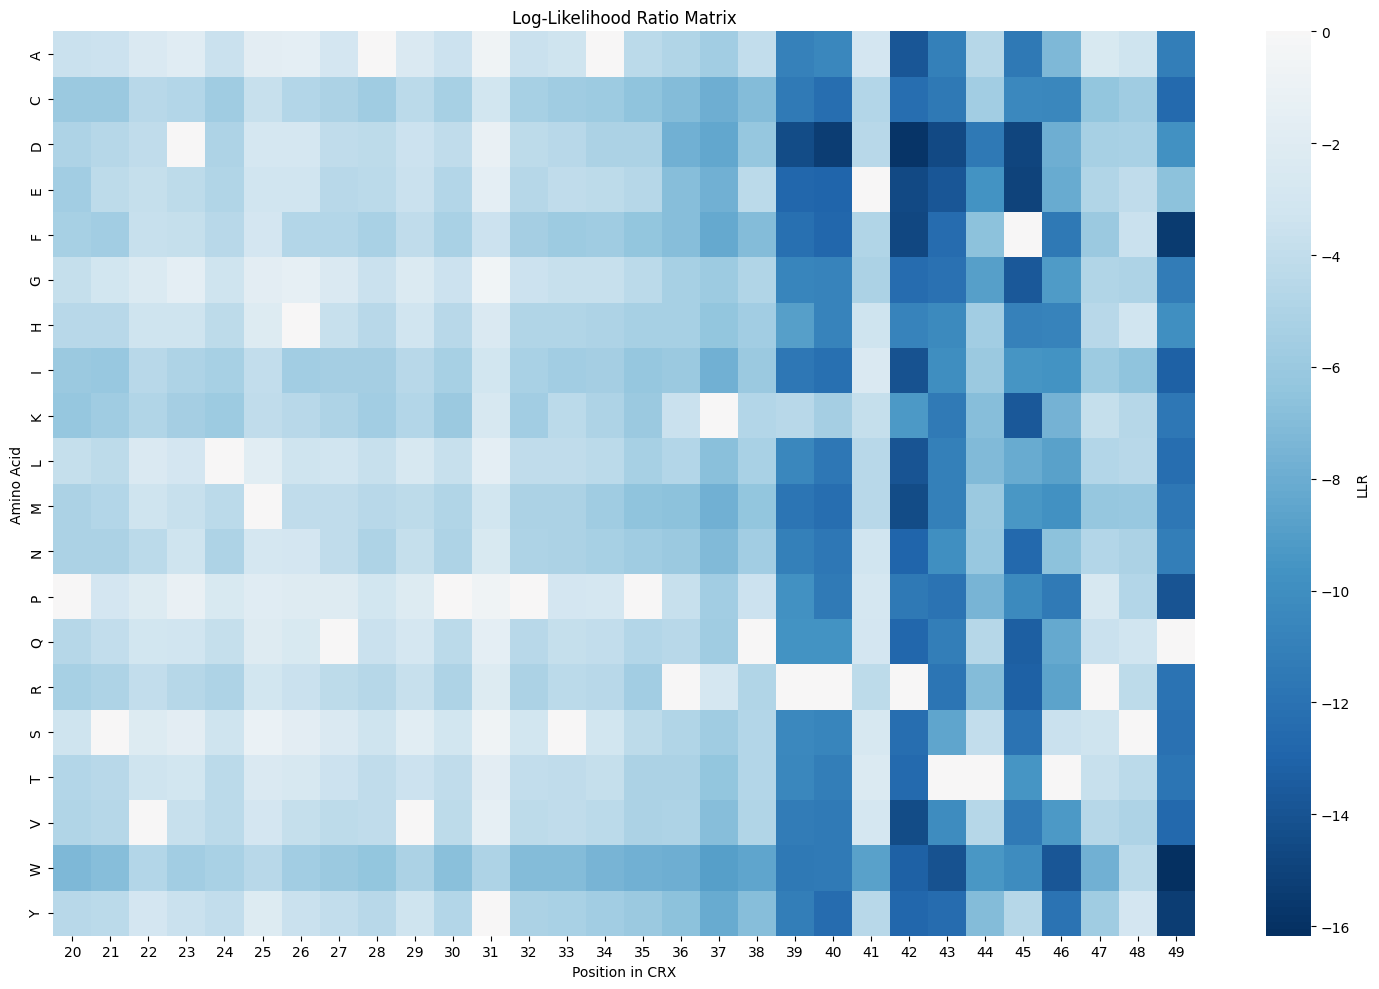

In [ ]:
llr_heatmap(crx_llr,positions=range(20,50))